In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import math
import warnings
warnings.filterwarnings('ignore')

## Generate dataframe

In [14]:
class VisualOutcomes:
    
    def vision_list(self, df):
        """
        Returns a list of visual acuity for patient.
        Input: patient Pandas dataframe.
        Output: list.
        """
        df['CreatedDate'] = pd.to_datetime(df['CreatedDate'])
        df.sort_values(by=['CreatedDate'], inplace=True)
        lst = df['visual_acuity'].dropna()
        return lst.to_list()
    
    def mean_vision(self, df):
        """
        Returns the mean vision of a patient.
        Input: patient Pandas dataframe.
        Output: float (LogMAR letters).
        """
        lst = self.vision_list(df)
        return np.mean(lst)

    def loss_from_peak(self, df):
        """
        Returns the VLP for a patient.
        Vision Loss from Peak (VLP) is defined as max vision minus last vision.
        Input: Pandas dataframe.
        Output: float (LogMAR letters).
        """
        visions = self.vision_list(df)
        return max(visions) - visions[-1]
    
    def overall_visual_change(self, df):
        """
        Returns the OVC for a patient.
        Overall Visual Change (OVC) is defined as last vision minus first vision.
        Input: Pandas dataframe.
        Output: float (LogMAR letters).
        """
        visions = self.vision_list(df)
        last = (visions[-1] + visions[-2] + visions[-3]) / 3
        first = visions[0]
        return last - first
    
    def peak_visual_improvement(self, df):
        """
        Returns the PVI for a patient.
        Peak Visual Improvement (PVI) is defined as max vision minus initial vision.
        Input: Pandas dataframe.
        Output: float (LogMAR letters).
        """
        visions = self.vision_list(df)
        return max(visions) - visions[0]

    def proportion_above_baseline(self, df):
        """
        Returns the proportion of time above starting vision.
        Input: patient Pandas dataframe.
        Output: float (percentage).
        """
        lst = self.vision_list(df)
        starting_vision = lst[0]
        above_lst = [i for i in lst if i > starting_vision]
        if len(above_lst) != 0:
            mean = sum(above_lst) / len(above_lst)
        else:
            mean = 0
        return mean

    def patient_clean(self, df, number_years):
        """
        Shortens a patient's dataframe to x years after initiation.
        Input: patient Pandas dataframe, integer.
        Output: Pandas dataframe.
        """
        dates = df['CreatedDate'].to_list()
        first = dates[0]
        cutoff = first.replace(year = first.year + number_years)
        df = df[df['CreatedDate'] < cutoff]
        return df

    def time_above_baseline(self, df, number_years):
        """
        Returns the number of days a patient spent above baseline in first x years.
        Input: Pandas dataframe, integer.
        Output: integer (days).
        """
        df["CreatedDate"] = pd.to_datetime(df["CreatedDate"])
        df.sort_values(by=['CreatedDate'], inplace=True)
        dates = df["CreatedDate"].to_list()
        if (dates[-1] - dates[0]).days > (number_years * 365):
            df = patient_clean(df, number_years)
            vision = df['visual_acuity'].to_list()
            dates2 = df["CreatedDate"].to_list()
            days = 0
            starting_vision = vision[0]
            for i in range(1, len(vision)):
                if vision[i] > vision[0]:
                    between = (dates2[i] - dates2[i-1]).days
                    days += between
            return days
        else:
            return 'nil'
        
    def time_above_baseline2(self, df):
        """
        Returns the number of days a patient spent above baseline in first x years.
        Input: Pandas dataframe, integer.
        Output: integer (days).
        """
        df["CreatedDate"] = pd.to_datetime(df["CreatedDate"])
        df.sort_values(by=['CreatedDate'], inplace=True)
        dates = df["CreatedDate"].to_list()
        vision = df['visual_acuity'].to_list()
        dates2 = df["CreatedDate"].to_list()
        days = 0
        starting_vision = vision[0]
        for i in range(1, len(vision)):
            if vision[i] > vision[0]:
                between = (dates2[i] - dates2[i-1]).days
                days += between
        return days

    def time_to_peak(self, df):
        """
        Returns the TPVI for a patient.
        Time to Peak Visual Improvement (TPVI) is defined in days.
        Input: Pandas dataframe.
        Output: integer (days).
        """
        df["CreatedDate"] = pd.to_datetime(df["CreatedDate"])
        df.sort_values(by=['CreatedDate'], inplace=True)
        dates = df["CreatedDate"].to_list()
        max_value = df['visual_acuity'].max()
        df_fin = df[df['visual_acuity'] == max_value]
        initial_date = dates[0]
        final_date = df_fin.CreatedDate.iloc[0]
        return (final_date - initial_date).days
    
    def baseline_vision(self, df):
        """
        Returns the baseline vision for a patient.
        Input: Pandas dataframe.
        Output: integer (LogMAR letters).
        """
        lst = self.vision_list(df)
        return lst[0]

In [17]:
class Dataframe(VisualOutcomes):
    
    def get_df(self):
        """
        Returns the dataframe to be analysed (all visits).
        """
        df = pd.read_csv('/home/jupyter/charliemacuject/pharma_reports/data/dme.csv')
        df.drop(columns=['Unnamed: 0'], inplace=True)
        return df
    
    def dataframe_gen(self, pdf, pat_id):
        """
        Returns a dataframe of all adherence measures and visual outcomes.
        For a singular patient only (will be one row).
        Input: integer (patient id).
        Output: Pandas dataframe.
        """
        df = pdf[pdf["id"] == pat_id]
        data = {'mean_vision': [VisualOutcomes.mean_vision(self, df)], 
                'time_above_baseline': [VisualOutcomes.time_above_baseline2(self, df)],
                'peak_visual_improvement': [VisualOutcomes.peak_visual_improvement(self, df)],
                'overall_visual_change': [VisualOutcomes.overall_visual_change(self, df)],
                'time_to_peak': [VisualOutcomes.time_to_peak(self, df)],
                'baseline': [VisualOutcomes.baseline_vision(self, df)],
                'visits': [len(df)]}
        return pd.DataFrame(data)

    
    def master_dataframe(self):
        """
        Returns a dataframe of statics for all patients.
        """
        df = self.get_df()
        id_list = df["id"].unique()
        frames = []
        for i in range(len(id_list)):
            try:
                pdf = self.dataframe_gen(df, id_list[i])
                pdf['id'] = i
                frames.append(pdf)
            except:
                i += 1
        master = pd.concat(frames)
        master.reset_index(inplace=True)
        master.drop(columns=['index'], inplace=True)
        return master

In [68]:
dataframe = Dataframe()
df = dataframe.master_dataframe()
df.head()

,mean_vision,time_above_baseline,peak_visual_improvement,overall_visual_change,time_to_peak,baseline,visits,id
0,70.588235,0,0.0,-9.333333,0,76.0,34,0
1,71.687500,54,4.0,-5.666667,328,76.0,18,1
2,73.250000,0,0.0,-26.000000,0,85.0,32,2
3,75.392857,1940,20.0,15.000000,987,65.0,58,3
4,75.600000,50,4.0,-4.000000,363,76.0,17,4


In [69]:
len(df)

181

# Predict patient vision
Goal: predict whether overall visual change (OVC, defined as last vision minus first vision) will be positive or negative for a given patient, using feature-engineered columns that summarise patient clinical history.

First, we need to append a column to the dataframe that will determine whether OVC is positive or negative. To do this, we'll write a function to return a 1 or a 0 based on the value of OVC in that row.

In [70]:
def label_ovc(row): return 1 if row['overall_visual_change'] > 0 else 0

Notice that the parameter being input to `label_ovc` is a Series object named row. Next, we use the `apply` function in Pandas to apply the function. We save the results in a new column in the dataframe.

In [71]:
df['OVC_outcome'] = df.apply(lambda row: label_ovc(row), axis=1)

Let's check that the new column is there.

In [72]:
df.head()

,mean_vision,time_above_baseline,peak_visual_improvement,overall_visual_change,time_to_peak,baseline,visits,id,OVC_outcome
0,70.588235,0,0.0,-9.333333,0,76.0,34,0,0
1,71.687500,54,4.0,-5.666667,328,76.0,18,1,0
2,73.250000,0,0.0,-26.000000,0,85.0,32,2,0
3,75.392857,1940,20.0,15.000000,987,65.0,58,3,1
4,75.600000,50,4.0,-4.000000,363,76.0,17,4,0


Finally, we'll save this amended dataframe so we don't have to run this every time.

In [74]:
df.to_csv('/home/jupyter/charliemacuject/pharma_reports/data/dme_features.csv')

## Baseline logistic regression

In [74]:
import matplotlib.pyplot as plt
from sklearn import linear_model
from scipy.special import expit

df = pd.read_csv('/home/jupyter/charliemacuject/pharma_reports/data/dme_features.csv')

X = df.drop(columns=['Unnamed: 0', 'overall_visual_change', 'OVC_outcome'])
y = df.OVC_outcome

X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=2)

clf = linear_model.LogisticRegression(C=1e5)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
score = accuracy_score(y_pred, y_test)
print("Accuracy: {}%".format(np.round(100*score,2)))

Accuracy: 82.61%


## Decision tree classifier

In [87]:
!pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz
import fastbook
fastbook.setup_book()

In [89]:
from sklearn.tree import DecisionTreeClassifier
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

m = DecisionTreeClassifier(max_leaf_nodes=4)
m.fit(X, y);

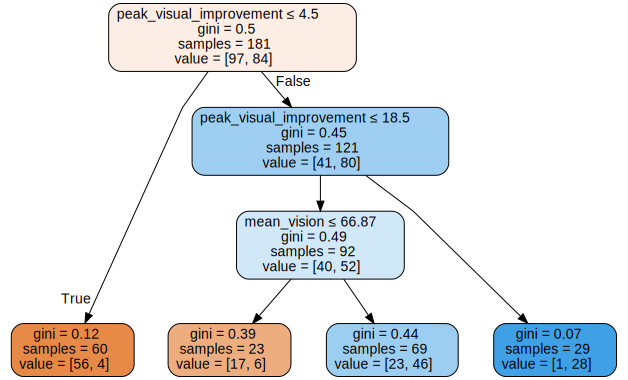

In [91]:
draw_tree(m, X, size=10, leaves_parallel=True, precision=2)

## Baseline XGBoost

We now need to save our features (`X`) and targets (`y`) by extracting them from the dataframe. Note that we need to drop `overall_visual_change` from the features as well as `OVC_outcome`, as we are classifying OVC rather than regressing it.

In [75]:
X = df.drop(columns=['overall_visual_change', 'OVC_outcome'])
y = df.OVC_outcome

Use scikit-learn to get our train-test split.

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
len(X_train), len(X_test)

(135, 46)

We now create the XGBoost model using `XGBClassifier`. We don't actually need to specify the objective here, but it's good for clarity. If we had more than two classes, we would instead use `multi:softmax`, but we'll just use a regular logistic function here.

In [41]:
xgb = XGBClassifier(booster='gbtree', objective='binary:logistic', max_depth=6,
                   learning_rate=0.1, n_estimators=100, random_state=2, n_jobs=-1)

Call `fit` on the model to train it.

In [42]:
xgb.fit(X_train, y_train)

[00:21:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=2,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Get the predictions and store them. Let's see how accurate we are.

In [45]:
y_pred = xgb.predict(X_test)
score = accuracy_score(y_pred, y_test)
print("Accuracy: {}%".format(np.round(100*score,2)))

Accuracy: 76.09%


We achieve 76% accuracy with no hyperparameter tuning and minimal feature engineering.

## Hyperparameter tuning

Using a baseline score of 76%, we will see if we can improve upon the classifier using hyperparameter tuning. However, we'll use cross validation accuracy this time to allow us to perform grid searches and random searches.

In [48]:
X = df.drop(columns=['overall_visual_change', 'OVC_outcome'])
y = df.OVC_outcome
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
xgb = XGBClassifier(booster='gbtree', objective='binary:logistic', random_state=2,
                   verbosity=0)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(xgb, X, y, cv=5)
print("Accuracy: ", np.round(scores, 2))
print('Accuracy mean: %0.2f' % (scores.mean()))

Accuracy:  [0.78 0.78 0.78 0.75 0.83]
Accuracy mean: 0.78


When fine-tuning hyperparameters, `GridSearchCV` and `RandomizedSearchCV` are the main options. However, we need to ensure that cross-validation and the searches split the data the same way. Thus, we use stratified k-fold, which includes the same percentage of target values in each fold. 

In [49]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)

The `kfold` variable can now be used inside `cross_val_score` and the search functions to ensure consistent results. We'll now redo our baseline using `kfold` so we can appropriately compare.

In [50]:
scores = cross_val_score(xgb, X, y, cv=kfold)
print('Accuracy:', np.round(scores, 2))
print('Accuracy mean: %0.2f' % (scores.mean()))

Accuracy: [0.81 0.75 0.92 0.72 0.75]
Accuracy mean: 0.79


`GridSearchCV` searches all possible combinations in a hyperparameter grid to find the best results. `RandomizedSearchCV` selects 10 random hyperparameter combinations to search, which makes it computationally less expensive than grid search.

We'll write a function that can swap between applying grid search and random search.

In [60]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

def grid_search(params, random=False):
    xgb = XGBClassifier(booster='gbtree', objective='binary:logistic',
                       random_state=2, verbosity=0)
    if random:
        grid = RandomizedSearchCV(xgb, params, cv=kfold, n_iter=20, n_jobs=-1)
    else:
        grid = GridSearchCV(xgb, params, cv=kfold, n_jobs=-1)
    grid.fit(X,y)
    best_params = grid.best_params_
    print("Best params: ", best_params)
    best_score = grid.best_score_
    print("Training score: {:.3f}".format(best_score))

There are many, many hyperparameters we could tune (see the XGBoost documentation [here](https://xgboost.readthedocs.io/en/latest/parameter.html)). We'll choose the key ones.

In [57]:
grid_search(params={'n_estimators':[100, 200, 400, 800]})

Best params:  {'n_estimators': 200}
Training score: 0.801


In [64]:
grid_search(params={'learning_rate':[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]})

Best params:  {'learning_rate': 0.05}
Training score: 0.801


In [ ]:
grid_search(params={'max_depth':[2, 3, 5, 6, 8]})

In [ ]:
grid_search(params={'gamma':[0, 0.1, 0.5, 1, 2, 5]})

In [ ]:
grid_search(params={'min_child_weight':[1, 2, 3, 4, 5]})

In [ ]:
grid_search(params={'subsample':[0.5, 0.7, 0.8, 0.9, 1]})

In [ ]:
grid_search(params={'colsample_bytree':[0.5, 0.7, 0.8, 0.9, 1]})

### Early stopping
Early stopping allows us to choose the number of training rounds without predefining it. Instead, we continue to train until no further gains are produced. A score is determined after each boosting round, and a peak score is achieved when all subsequent scores fail to produce any gains. We choose the number of rounds after peak to examine. 

In [65]:
model = XGBClassifier(booster='gbtree', objective='binary:logistic', random_state=2)
eval_set = [(X_test, y_test)]
eval_metric='error'
model.fit(X_train, y_train, eval_metric="error", eval_set=eval_set, early_stopping_rounds=10, 
          verbose=True)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[0]	validation_0-error:0.21739
[1]	validation_0-error:0.17391
[2]	validation_0-error:0.19565
[3]	validation_0-error:0.23913
[4]	validation_0-error:0.26087
[5]	validation_0-error:0.26087
[6]	validation_0-error:0.26087
[7]	validation_0-error:0.26087
[8]	validation_0-error:0.23913
[9]	validation_0-error:0.23913
[10]	validation_0-error:0.26087
Accuracy: 82.61%


Early stopping reveals that `n_estimators = 2` gives the best result. We try again, but using a maximum of 5000 trees and 100 consecutive rounds of non-improvement.

In [67]:
model = XGBClassifier(random_state=2, n_estimators=5000)
eval_set = [(X_test, y_test)]
eval_metric="error"
model.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, 
          early_stopping_rounds=100, verbose=False)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 82.61%


## Random forest

Instead of using a normal decision tree, we can bag predictors using the following procedure:
1. Randomly choose a subset of features ("bootstap replicates of learning set").
2. Train a model using this subset.
3. Save that model, and repeat step 1.
4. Using these various trained models, make a prediction, and take the average.

This procedure is known as _bagging_. The intuition behind it is this: although each of the models trained on a subset of data will make more errors than a model trained on the full dataset, those errors will not be correlated with each other. The average of errors is thus zero.

In [94]:
from sklearn.ensemble import RandomForestClassifier
df = pd.read_csv('/home/jupyter/charliemacuject/pharma_reports/data/dme_features.csv')
df.columns

Index(['Unnamed: 0', 'mean_vision', 'time_above_baseline',
       'peak_visual_improvement', 'overall_visual_change', 'time_to_peak',
       'baseline', 'visits', 'id', 'OVC_outcome'],
      dtype='object')

Set the dependent variable.

In [95]:
X = df.drop(columns=['Unnamed: 0', 'OVC_outcome', 'overall_visual_change'])
y = df.OVC_outcome

We create a random forest by specifying parameters that indicate how many trees should be in the forest, how we should subset the data items (the rows) and how we should subset the fields (the columns).

In [96]:
def rf(xs, y, n_estimators=40, max_samples=135,
      max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators,
                                max_samples=max_samples, max_features=max_features,
                                min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs,y)

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

In [98]:
def accuracy_print(m, X_train, y_train, X_test, y_test): 
    train_score = accuracy_score(m.predict(X_train), y_train)
    test_score = accuracy_score(m.predict(X_test), y_test)
    return train_score, test_score

In [99]:
m = rf(X_train, y_train);
accuracy_print(m, X_train, y_train, X_test, y_test)

(0.9037037037037037, 0.8478260869565217)

We want to be able to see how this model is making its predictions using _feature importance_. We can grab this using an sklearn built in attribute.

In [100]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [101]:
fi = rf_feat_importance(m, X_train)
fi[:10]

,cols,imp
2,peak_visual_improvement,0.292336
1,time_above_baseline,0.251016
3,time_to_peak,0.126540
0,mean_vision,0.110089
4,baseline,0.093376
5,visits,0.083052
6,id,0.043590


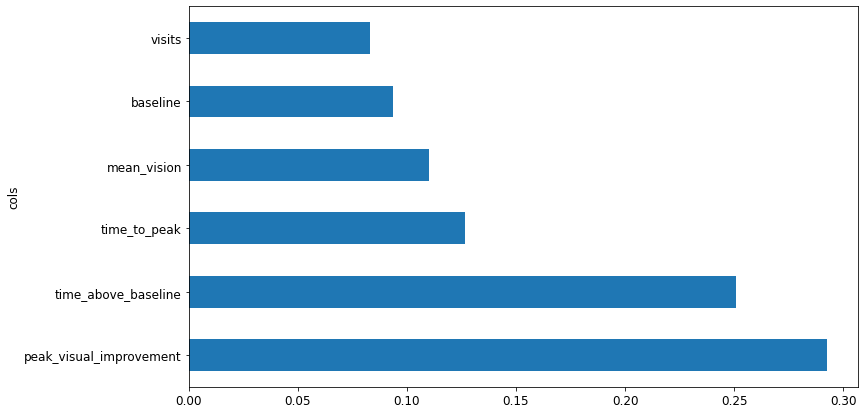

In [102]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:6]);

We'd like to understand the relationship between predictors and OVC. It's a good idea to first check the distribution of important predictors:

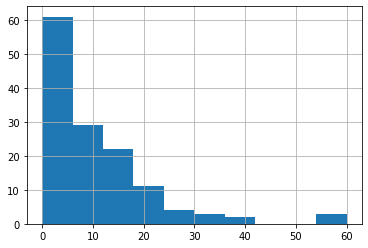

In [10]:
ax = X_train.peak_visual_improvement.hist()

We now examine _partial dependence plots_. The question we are asking is: if a row varied on nothing other than the feature in question, how would it impact the dependent variable? In other words, how does `peak_visual_improvement` impact sales price, all other things being equal?

We can't just take an average to answer this question. This is because other things vary from patient to patient, not just their PVIs. This approach would instead capture the effect of how every other field changed along with PVI and how that overall change affected OVC.

Instead, what we do is replace every single value in the PVI column with 0, and then calculate the predicted OVC, and then average. Then we do the same for PVI = 1.0, 2.0 and so on. This isolates the effect of only PVI.

With these averages, we can then plot each of these years on the x-axis, and each of the predictions on the y-axis. This is a partial dependence plot.

In [53]:
from sklearn.inspection import plot_partial_dependence

#fig, ax = plt.subplots(figsize=(12,4))
#plot_partial_dependence(m, df, ['peak_visual_improvement', 'overall_visual_change'],
                       #grid_resolution=20, ax=ax);

## Tree interpreter

It would be nice to know exactly _how_ predictions were generated given any individual patient. What were the most important factors, and can we quantify how these factors influenced prediction?

Above, we calculated feature importances across the entire random forest. Here, we do the same thing for a single row of data, representing a single patient.

In [14]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

Let's pick the first few rows of our validation set.

In [15]:
row = X_test.iloc[:5]

We can then pass these to `treeinterpreter`.

In [17]:
prediction, bias, contributions = treeinterpreter.predict(m, row.values)

The clearest way to display the contributions is with a waterfall plot. This shows how the positive and negative contributions from all the independent variables sum to create the final prediction.

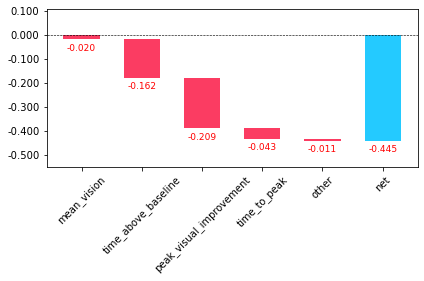

In [37]:
conts = [-0.0196, -0.162, -0.209, -0.043, 0.004, -0.010, -0.005]
waterfall(X_test.columns, conts, threshold=0.08, 
          rotation_value=45,formatting='{:,.3f}');

## Using a neural network

In [41]:
df = pd.read_csv('/home/jupyter/charliemacuject/pharma_reports/data/dme_features.csv')
df.drop(columns=['Unnamed: 0', 'overall_visual_change'], inplace=True)
df.columns

Index(['mean_vision', 'time_above_baseline', 'peak_visual_improvement',
       'time_to_peak', 'baseline', 'visits', 'id', 'OVC_outcome'],
      dtype='object')

In [42]:
dep_var = 'OVC_outcome'

In [65]:
from fastai import *

procs_nn = [Normalize]
to_nn = TabularPandas(df, procs_nn, y_names=dep_var)

In [66]:
dls = to_nn.dataloaders(64)

In [69]:
learn = tabular_learner(dls, layers=[500,250])

In [71]:
#learn.fit_one_cycle(5, 1e-2)

# Pattern analysis of interval length

## Visualising individual patients

Import and clean the dataset. We will extract an individual patient for simplicity and visualisation purposes.

In [8]:
class ImportClean:
    
    def __init__(self, df):
        self.df = df
        
    def clean(self):
        cdf = self.df
        cdf.CreatedDate = pd.to_datetime(cdf.CreatedDate)
        cdf.drop(columns=['Unnamed: 0'], inplace=True)
        return cdf
    
    def interval_column(self):
        df = self.clean()
        id_list = df.id.unique()
        df.CreatedDate = pd.to_datetime(df.CreatedDate)
        frames = []
        for eye in id_list:
            interval_list = [0]
            pdf = df[df.id == eye]
            pdf.sort_values(by=['CreatedDate'], inplace=True)
            for i in range(len(pdf)-1):
                interval = np.round((pdf.CreatedDate.iloc[i+1] - pdf.CreatedDate.iloc[i]).days / 7)
                interval_list.append(interval)
            pdf['Interval'] = interval_list
            frames.append(pdf)
        return pd.concat(frames)
    
df = pd.read_csv('/home/jupyter/charliemacuject/pharma_reports/data/dme.csv')
df = ImportClean(df)
df = df.interval_column()
pdf = df[df.id == '25593']
pdf.sort_values(by=['CreatedDate'], inplace=True)
pdf.set_index('CreatedDate', inplace=True)

The simplest place to start with a pattern analysis would be to visualise rolling averages. We use it to analyse the time series data by calculating averages of different subsets of the complete dataset. The moving average allows the capture of short-term fluctuations whilst making long-term trends clearer.

The code below calculates a simple moving average, a cumulative moving average, and an exponentially weighted average, for interval length. This uses the `pandas` built-in `rolling` function.

In [14]:
pdf['SMA_4'] = pdf['Interval'].rolling(window=4).mean()
pdf['CMA_4'] = pdf['Interval'].expanding(min_periods=4).mean()
pdf['EMA'] = pdf['Interval'].ewm(span=10, adjust=False).mean()

We then plot all of these in the same plot.

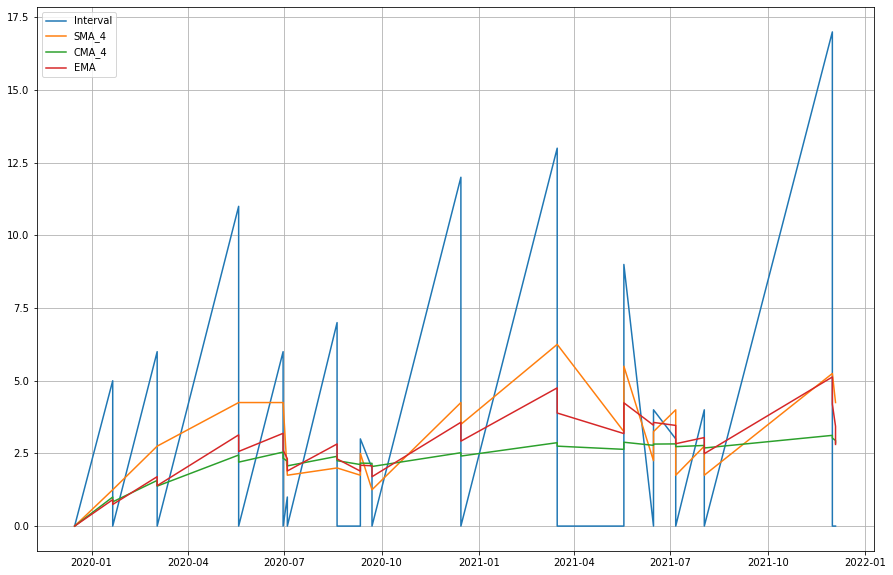

In [16]:
plt.figure(figsize=[15,10])
plt.grid(True)
plt.plot(pdf['Interval'],label='Interval')
plt.plot(pdf['SMA_4'],label='SMA_4')
plt.plot(pdf['CMA_4'],label='CMA_4')
plt.plot(pdf['EMA'],label='EMA')
plt.legend(loc=2);

This is quite messy. It's hard to visualise what each of the lines are showing. We also seem to have a lot of visits where the interval length is zero. Let's see what happens if we remove these.

In [29]:
pdf = pdf[(pdf.Interval != 0) | (pdf.index == '2019-12-16')]

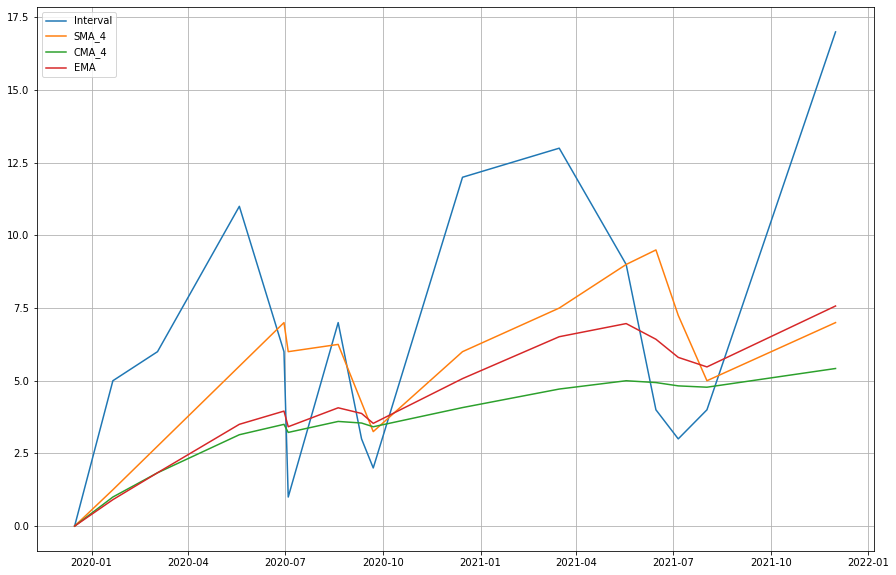

In [30]:
pdf['SMA_4'] = pdf['Interval'].rolling(window=4).mean()
pdf['CMA_4'] = pdf['Interval'].expanding(min_periods=4).mean()
pdf['EMA'] = pdf['Interval'].ewm(span=10, adjust=False).mean()

plt.figure(figsize=[15,10])
plt.grid(True)
plt.plot(pdf['Interval'],label='Interval')
plt.plot(pdf['SMA_4'],label='SMA_4')
plt.plot(pdf['CMA_4'],label='CMA_4')
plt.plot(pdf['EMA'],label='EMA')
plt.legend(loc=2);

This is much better. It gives us a clearer picture of the trends in patient interval length. Here are some insights about the different kinds of moving averages:
* The _simple moving average_ (SMA) uses a sliding window to take the average over a set number of discrete periods. It is an equally weighted mean, and because it only considers the last few visits, its variance resembles the original time series much more closely than the other types of moving averages.
* The _cumulative moving average_ (CMA) considers all prior observations. For this reason, it often smooths too much, as data points in the distant past affect the current observation mean. Short-term trends are difficult to discern.
* The _exponential moving average_ (EMA) gives higher weight to recent interval lengths, whilst still considering older visits, which it 'forgets' using exponential decay. Because of the higher weight given to recent data, EMAs are more responsive to changes whilst still capturing the long-term trend.

Let's try one more patient to see how that looks. We'll bundle up all the above steps into a function.

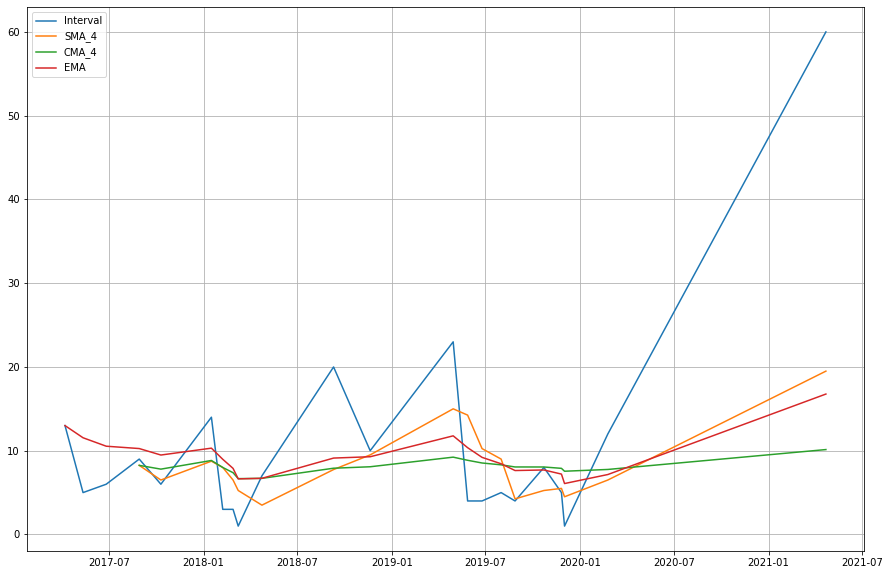

In [36]:
def patient_averages(df):
    id_list = df.id.unique()
    num = np.random.choice(id_list)
    pdf = df[df.id == num]
    pdf.sort_values(by=['CreatedDate'], inplace=True)
    pdf.set_index('CreatedDate', inplace=True)
    pdf = pdf[(pdf.Interval != 0) | (pdf.index == '2019-12-16')]
    pdf['SMA_4'] = pdf['Interval'].rolling(window=4).mean()
    pdf['CMA_4'] = pdf['Interval'].expanding(min_periods=4).mean()
    pdf['EMA'] = pdf['Interval'].ewm(span=10, adjust=False).mean()
    plt.figure(figsize=[15,10])
    plt.grid(True)
    plt.plot(pdf['Interval'],label='Interval')
    plt.plot(pdf['SMA_4'],label='SMA_4')
    plt.plot(pdf['CMA_4'],label='CMA_4')
    plt.plot(pdf['EMA'],label='EMA')
    plt.legend(loc=2);
    
patient_averages(df)

## Aggregating the data - density line chart

Since we are dealing with multiple patients, each with their own time series of interval length, we'd like to view these series simultaneously without having overwhelming data or cluttered data. That is, we wish to calculate a discrete density representation of time series.

To compare individual patients, we need a way to standardise the data. To do this, we'll append a column to tell us how many months it is since the patient started treatment.

In [49]:
def month_column(pdf):
    pdf.sort_values(by=['CreatedDate'], inplace=True)
    visions = pdf['visual_acuity'].to_list()
    initial_date = pdf.CreatedDate.iloc[0]
    months_list = [0]
    for i in range(len(pdf)-1):
        months = round((pdf.CreatedDate.iloc[i] - initial_date).days / 28)
        months_list.append(months)
    pdf['month_since_start'] = months_list
    return pdf

def month_all(df):
    id_list = df.id.unique()
    frames = []
    for eye in id_list:
        pdf = df[df.id == eye]
        pdf.CreatedDate = pd.to_datetime(pdf.CreatedDate)
        pdf.sort_values(by=['CreatedDate'], inplace=True)
        pdf = month_column(pdf)
        pdf.set_index('CreatedDate', inplace=True)
        pdf = pdf[pdf.Interval != 0]
        frames.append(pdf)
    return pd.concat(frames)

tdf = month_all(df)
tdf.head()

,id,Laterality,visual_acuity,InjToday,InjNext,NextInt,Interval,month_since_start
CreatedDate,,,,,,,,
2017-03-22,19913,Left,76.0,NaN,NaN,NaN,4.0,0
2017-04-07,19913,Left,76.0,Lucentis,Lucentis,4.0,2.0,1
2017-06-06,19913,Left,76.0,Lucentis,Lucentis,NaN,9.0,2
2017-08-22,19913,Left,70.0,Lucentis,Lucentis,4.0,11.0,4
2017-09-03,19913,Left,76.0,Avastin,NaN,NaN,2.0,6


In [52]:
tdf = tdf[(tdf.Interval < 12) & (tdf.month_since_start < 50)]
source = tdf

alt.Chart(
    source,
    title="Interval length heatmap all DME patients"
).mark_rect().encode(
    x='month_since_start',
    y='Interval',
    color=alt.Color('max(Interval):Q', scale=alt.Scale(scheme="inferno"))
).properties(width=550)

alt.Chart(...)

In [39]:
import altair as alt
from vega_datasets import data

# Since the data is more than 5,000 rows we'll import it from a URL
source = data.seattle_temps.url

alt.Chart(
    source,
    title="2010 Daily High Temperature (F) in Seattle, WA"
).mark_rect().encode(
    x='date(date):O',
    y='month(date):O',
    color=alt.Color('max(temp):Q', scale=alt.Scale(scheme="inferno")),
    tooltip=[
        alt.Tooltip('monthdate(date):T', title='Date'),
        alt.Tooltip('max(temp):Q', title='Max Temp')
    ]
).properties(width=550)

alt.Chart(...)

# Unsupervised clustering

In [1]:
from sklearn import manifold

We want to classify the doctors to see if there is any difference in interval pattern. We'll label the Devinder, Eric and Launceston data as 0, 1 and 2, respectively. Let's import these datasets now.

In [6]:
df0 = pd.read_csv('/home/jupyter/charliemacuject/pharma_reports/data/dme.csv')
df1 = pd.read_csv('/home/jupyter/charliemacuject/pharma_reports/data/DME_Eric.csv')
df2 = pd.read_csv('/home/jupyter/charliemacuject/pharma_reports/data/DME_Laun.csv')

Again, we'll use the `ImportClean` class from above to clean the data, and append a column that tells us the interval.

In [ ]:
df_list = [df0, df1, df2]
new_list = []
for df in df_list:
    df = pd.read_csv('/home/jupyter/charliemacuject/pharma_reports/data/dme.csv')
    df = ImportClean(df)
    df = df.interval_column()
    new_list.append(df)

In [2]:
tsne = manifold.TSNE(n_components=2, random_state=42)
transformed_data = tsne.fit_transform(pixel_values[:3000, :])

Here, we are creating the pandas dataframe from a numpy array. `x` and `y` are the two components from the t-SNE decomposition, and targets is the actual number of the image.

In [ ]:
tsne_df = pd.DataFrame(
    np.column_stack((transformed_data, targets[:3000])),
    columns = ["x", "y", "targets"])
tsne_df.loc[:, "targets"] = tsne_df.targets.astype(int)

Finally, we can plot the decomposition.

In [ ]:
grid = sns.FacetGrid(tsne_df, hue='targets', height=8)
grid.map(plt.scatter, "x", "y").add_legend();